# Analyse camera tracking data

### created by Chagas, Andre M 
### Distributed under CC BY SA 4.0 20200310

---

all paths are described in relation to the location of the jupyter notebook.

In [1]:
#import necessary libraries
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import support

In [3]:
os.listdir(csvPath+animalFolder)

['Arya2020-03-24T09_21_540.csv']

In [4]:
#location of csv files:
csvPath = "../../test_data/csvs/"

#select which animal to analyse
animalFolder = "Arya/"

csvPath = csvPath + animalFolder

#get a list of the files so they can be analysed in a batch:
csvFiles = [csvPath+f for f in os.listdir(csvPath) if os.path.isfile(os.path.join(csvPath, f))]

print(csvFiles)

['../../test_data/csvs/Arya/Arya2020-03-24T09_21_540.csv']


In [5]:
#use the next line to analyse only one session for one animal and change "[0]" to whatever session number is to be analysed
#allData = support.load_n_join_DFs(csvFiles[0])

# use the next line to analyse all sessions for one specific animal
allData = support.load_n_join_DFs(csvFiles) 



In [6]:
# some basic numbers on the amount of time animal and wheel were moving:

#total number of frames:
print("number of recorded frames: " + str(len(allData)))
#number of frames the wheel was moving 
print("number of wheel moving frames: " + str(np.sum(allData["wheelmoving"])))
#number of frames the wheel was moving and the animal was also moving (which could indicate false positives):
print ("frames where both wheel and mouse were moving: "+ str(np.sum(allData["wheelmoving"] & allData["mousemoving"])))
#number of frames of mouse moving
print ("number of mouse moving frames: "+ str(np.sum(allData["mousemoving"])))




#total recording duration
#np.sum(allData["Item3.Item1.frameinterval"])/60

number of recorded frames: 429638
number of wheel moving frames: 1680
frames where both wheel and mouse were moving: 440
number of mouse moving frames: 7712


---
**travelled distance**


if there was only the mouse on the cage, the travelled distance would be: 
- given by pythagoras a2 = b2 + c2 for where b and c are x and y dimensions, and their magnitude is the difference between 2 consecutive frames.

But the mouse has a wheel in its cage, so we need to add the "distance" the wheel
travelled to the distance travelled by the animal (since while running on the wheel,
the animal is static in relation to the cage and camera).

so in the end we want the distance travelled by the mouse while it was NOT on 
the wheel, plus the distance travelled by the wheel, while the wheel was moving


In [7]:
### add boolean data for when mouse mouse was moving but wheel was NOT moving
allData  = allData.join(pd.Series(data = (allData["mousemoving"] & ~allData["wheelmoving"]),name="onlymouse"))


In [11]:
### mouse distance X 
mouseXdist = allData["mouse.Item1.mouse.Centroid.X"].diff()
### mouse distance Y 
mouseYdist = allData["mouse.Item1.mouse.Centroid.Y"].diff()

# mouse movement (excluding the times when the mouse was on the wheel) using pythagoras 
onlyMouseDist = np.sqrt((mouseXdist[allData["onlymouse"]]**2)+(mouseYdist[allData["onlymouse"]]**2)) 
onlyMouseDist = onlyMouseDist.sum()
print("distance travelled in pixels: " + str(onlyMouseDist))
#plt.plot(onlyMouseDist)

distance travelled in pixels: 100833.25859477808


---

#### before calculating the rest of total movement, we need to make some considerations on the wheel movement:




**calculate distance travelled while on the wheel**

The wheel has a black marker that is used to track its movement. the tracker is set close to the center of the wheel and the readings we have to work with are X and Y positions of this tracker in relation to the bottom left corner of the WheelROI (the next cell plots the raw data for better visualisation)

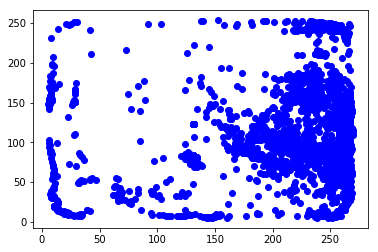

In [12]:
plt.plot(allData["wheel.Item2.wheel.Centroid.X"],allData["wheel.Item2.wheel.Centroid.Y"],'bo')

the above graph shows all detected X against Y positions of the wheel marker (this is a bit noisy at the moment, but can/should be cleaned up using bonsai). Gap on the top can happen because of a glare from the IR light from the camera leds.

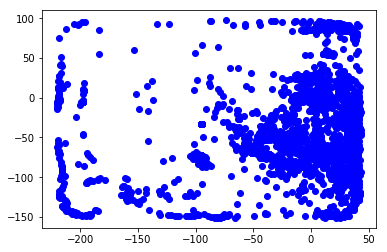

In [13]:
# get the x and y average positions are remove them from each dimension, so to "center" the wheel
wheelXavg = allData["wheel.Item2.wheel.Centroid.X"].mean()
wheelYavg = allData["wheel.Item2.wheel.Centroid.Y"].mean()


allData = allData.join(pd.Series(data = (allData["wheel.Item2.wheel.Centroid.X"]-wheelXavg),name="wheelXcentered"))
allData = allData.join(pd.Series(data = (allData["wheel.Item2.wheel.Centroid.Y"]-wheelYavg),name="wheelYcentered"))


plt.plot(allData["wheel.Item2.wheel.Centroid.X"]-wheelXavg,allData["wheel.Item2.wheel.Centroid.Y"]-wheelYavg,"bo")


With X' and Y' centered values, we can get distance travelled :  

1.calculate the tangent(alpha) value for each frame tan(alpha) = Y'/X'.  
2.calculate the arctan(alpha) which gives alpha in radians  
3.multiply radians by the radius (either the marker distance from the centre of the wheel, or the wheel radius -  which could be more accurate in terms of distance)  
4.get the difference between each frame  
5.sum the module of the differences  




In [14]:
#wheelradius: either the distance from marker to wheel center or actual wheel radius.
# here just set to 1 for demonstration purposes
wheelRadius = 1
#1
tanA = allData["wheelYcentered"]/allData["wheelXcentered"]
#2
arcTanA = np.arctan(tanA)
#3
wheelMov = arcTanA*wheelRadius
#4 
wheelDist = np.diff(wheelMov)
#5
wheelDist = np.sum(np.abs(wheelMov))
print(wheelDist)
#plt.plot(wheelDist)

622395.2426969332


Now that we have the wheel dist, we can add it to the already calculated mouse distance

In [76]:
totalDist = onlyMouseDist + wheelDist
print("total distance: " + str(totalDist))
print("distance percentage on wheel: " + str(wheelDist/totalDist) )
#note that for now the wheel radius is wrong, so the distance on the wheel is going to be smaller

total distance: 35522.62792258647
distance percentage on wheel: 0.22925122785462393


In [15]:
np.sum(np.abs(np.diff(np.arctan(tanA.dropna()))*wheelRadius))

219223.5679553041

#### Moving time

Get the total moving time, wheel plus non-wheel


In [18]:
totalTime = allData["frameinterval"]
movingTime = totalTime[allData["onlymouse"]].sum() + totalTime[allData["wheelmoving"]].sum()

print("recording time: " + str(totalTime.sum()/60)+ " minutes")
print("total moving time: " + str(movingTime/60) + " minutes")
print("wheel moving time: "+ str(totalTime[allData["wheelmoving"]].sum()/60)+ " minutes")
print("mouse moving time: " + str(totalTime[allData["onlymouse"]].sum()/60)+ " minutes")
print("percentage of moving time spent on wheel: " + str(totalTime[allData["wheelmoving"]].sum()/movingTime))

recording time: 238.09126762666662 minutes
total moving time: 4.959583786666917 minutes
wheel moving time: 0.9298432000027484 minutes
mouse moving time: 4.029740586664169 minutes
percentage of moving time spent on wheel: 0.18748411963570205


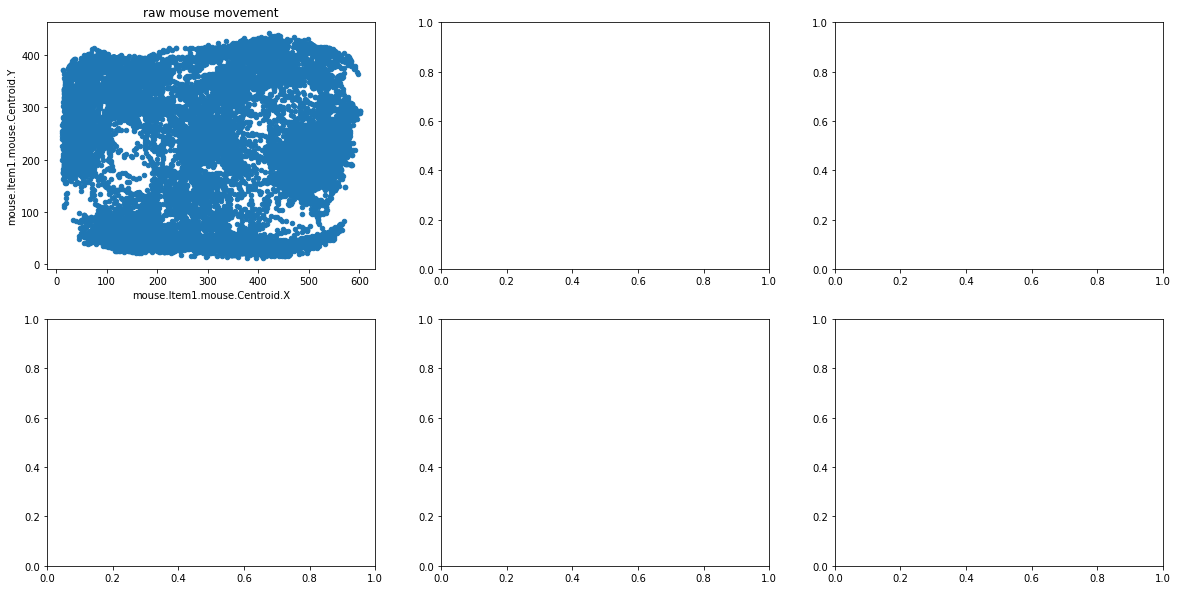

In [9]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 10))

allData.plot(x="mouse.Item1.mouse.Centroid.X",
         y="mouse.Item1.mouse.Centroid.Y",
         kind="scatter",
         ax=axes[0,0],
         title="raw mouse movement")



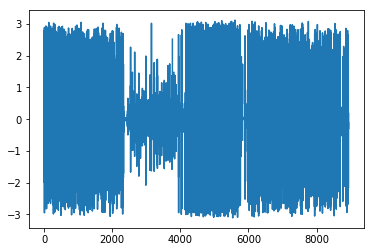

In [79]:
plt.plot(np.diff(np.arctan(tanA)))*wheelRadius